While I'm waiting for a full parmaeter cube to be generated, I'm testing the emulation framework I've made so far. /

In [19]:
import numpy as np
from src.emulator import build_emulator, emulate, emulate_wrt_r, get_plot_data
from src.allCorrFunc import RBINS
from src.doBatchCalls import BOUNDS, N_PER_DIM

In [20]:
for key, val in BOUNDS.iteritems():
    print key
    print np.linspace(val[0], val[1], num=N_PER_DIM)
    print '*'*30

logMmin
[ 11.7         11.96666667  12.23333333  12.5       ]
******************************
f_c
[ 0.1         0.23333333  0.36666667  0.5       ]
******************************
logM0
[ 10.  11.  12.  13.]
******************************
sigma_logM
[ 0.2         0.36666667  0.53333333  0.7       ]
******************************
logM1
[ 13.1  13.5  13.9  14.3]
******************************
alpha
[ 0.75        0.91666667  1.08333333  1.25      ]
******************************


In [21]:
bias = False
y_param = 'logMmin'
#y_param = 'f_c'
#y_param = 'logM0'
#y_param = 'logM1'
#y_param = 'sigma_logM'
#y_param = 'alpha'

#param_2 = 'logMmin'
param_2 = 'sigma_logM'
#param_2 = 'f_c'
#parma_2 = 'logM0'

#param_3 = 'sigma_logM'
param_3 = 'logM0'
#param_3='f_c'

#param_4 = 'alpha'
param_4 = 'logM1'
#param_4 = 'f_c'

#param_5= 'logM1'
#param_5 = 'f_c'
param_5='alpha'

emulation_point = [('f_c', 0.233), 
                   ('logM0', 12.0), ('sigma_logM', 0.533), ('alpha', 1.083),
                   ('logM1', 13.5), ('logMmin', 12.233)]

fiducial_point = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02, 
                  'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
fixed_params = {key:val for key, val in emulation_point}
#em_params = {}
em_params = {param_2:fixed_params[param_2]}#, param_3:fixed_params[param_3],
            #param_4:fixed_params[param_4], param_5:fixed_params[param_5]} #varying y_param, holding this fixed in the emulator now. 
del fixed_params[y_param]
del fixed_params[param_2]
#del fixed_params[param_3]
#del fixed_params[param_4]
#del fixed_params[param_5]

In [22]:
#%%timeit
from time import time
t0 = time()
gp, log_xi, log_xi_cov = build_emulator(fixed_params, bias=bias)
print '%.3f s'%(time()-t0)

16 Points used for training.
Initial Params:  [ 0.481   0.1349  0.089   0.04  ]
GP Optimization Failed.
GP Params:  [ 0.44091498  0.13460585  0.08722752  0.03892374]
22.506 s


In [23]:
from scipy.linalg import det, eigh, inv
print log_xi_cov[0,0]
print det(log_xi_cov/log_xi_cov[0,0])

7.15965148787e-06
1.66212060476e-159


In [24]:
from scipy.linalg import eigvals
c = log_xi_cov[:18,:][:,:18]
for e in eigvals(c):
    assert e > 0

In [25]:
log_xi_mean = log_xi.mean()
log_xi-=log_xi_mean

In [26]:
#gp.kernel[:] = [0.175, -0.32, -3.4]

In [27]:
yp = np.linspace(BOUNDS[y_param][0],BOUNDS[y_param][1], num=N_PER_DIM)
N = 200
rpoints = np.linspace(-1, 1.5, N)
RBIN_CENTERS = ((RBINS[:-1]+RBINS[1:])/2)
outputs = emulate_wrt_r(gp, log_xi, em_params, rpoints,
                                    y_param=y_param,y_points=yp)
print len(outputs[0][0])

200


In [28]:
from matplotlib import pyplot as plt
from itertools import cycle
%matplotlib inline
#plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
colors = cycle(sns.color_palette())

In [29]:
print log_xi.shape

(288,)


In [30]:
plot_r, plot_xi, plot_xi_err = get_plot_data(em_params, fixed_params, bias=bias)

(200,) (200,)
(200,) (200,)
(200,) (200,)
(200,) (200,)


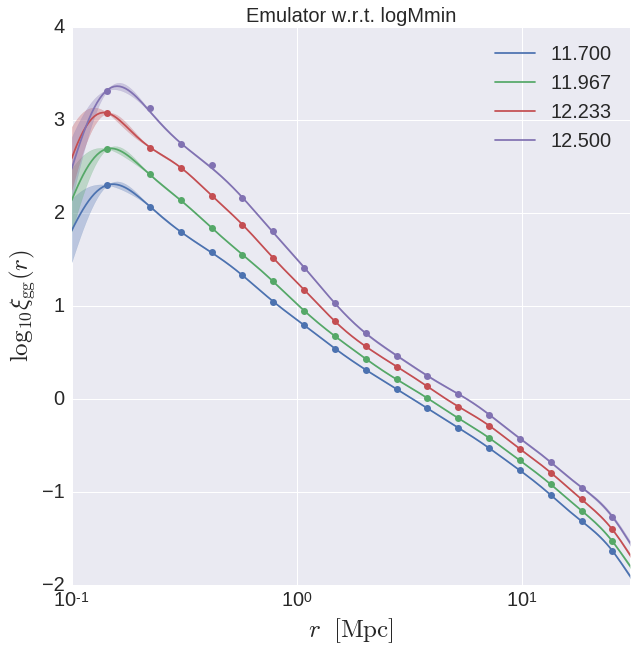

In [31]:
fig = plt.figure(figsize = (10, 10))
for label, (log_xi_pred, log_xi_err),pr, px, err,c in zip(yp, outputs,plot_r, plot_xi,plot_xi_err,colors):

    print rpoints.shape, log_xi_pred.shape
    plt.plot(10**rpoints, (log_xi_pred+log_xi_mean),label='%.3f'%label,color = c)
    #plt.fill_between(10**rpoints,10**(log_xi_pred+log_xi_mean+log_xi_err),
    #                 10**(log_xi_pred+log_xi_mean-log_xi_err), color = c, alpha = 0.3)
    
    plt.fill_between(10**rpoints,log_xi_pred+log_xi_mean+log_xi_err,
                     log_xi_pred+log_xi_mean-log_xi_err, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
if bias:
    plt.ylim(ymin = 0, ymax = 15)
else:
    plt.ylim(ymin = -2, ymax = 4)
plt.title("Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
if bias:
    plt.ylabel(r'$\xi_{\rm gg}/\xi_{\rm mm} }$', fontsize=25)
else:
    plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=20)  

In [32]:
N = 200
plot_xi = plot_xi.T #switch rows and cols
plot_xi_err = plot_xi_err.T
plot_r = plot_r.T
yp = np.linspace(BOUNDS[y_param][0],BOUNDS[y_param][1], num=N)
plot_yp = np.linspace(BOUNDS[y_param][0],BOUNDS[y_param][1], num=N_PER_DIM)
rpoints = np.log10(RBIN_CENTERS)
#print rpoints
outputs = emulate(gp, log_xi, em_params,x_param=y_param, x_points=yp,y_param='r',y_points=rpoints)

In [33]:
i = 4
#remove some points
rpoints=rpoints[::i]
outputs=outputs[::i]
plot_r=plot_r[::i]
plot_xi=plot_xi[::i]
plot_xi_err = plot_xi_err[::i]

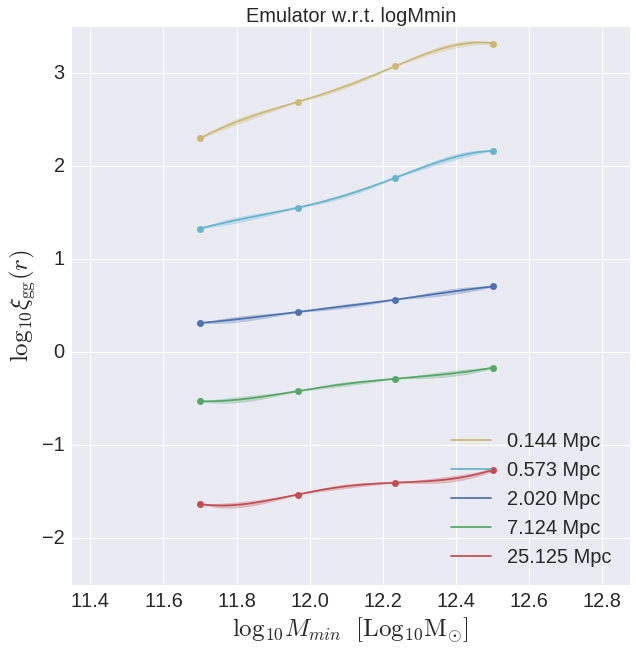

In [34]:
fig = plt.figure(figsize = (10, 10))

for label, (log_xi_pred, log_xi_err),px,err,c in zip(rpoints, outputs, plot_xi,plot_xi_err,colors):

    plt.plot(yp, (log_xi_pred+log_xi_mean),label='%.3f Mpc'%(10**label),color = c)
    
    plt.fill_between(yp,log_xi_pred+log_xi_mean+log_xi_err,
                     log_xi_pred+log_xi_mean-log_xi_err, color = c, alpha = 0.3)
    plt.errorbar(plot_yp, px,err, color =c,fmt = 'o')
    
plt.xlim(xmin = 0.97*BOUNDS[y_param][0], xmax = BOUNDS[y_param][1]*1.03)
if bias:
    plt.ylim(ymin=0, ymax=15)
else:
    plt.ylim(ymin = -2.5, ymax = 3.5)
plt.title("Emulator w.r.t. %s"%y_param, fontsize =20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\log_{10}{M_{min}}}$  $\rm{[Log_{10} M_{\odot}]}$', fontsize=25)
#plt.xlabel(r'$\alpha$ ', fontsize=25)
if bias:
    plt.ylabel(r'$\xi_{\rm gg}/\xi_{\rm mm} }$', fontsize=25)
else:
    plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=20)  